In [5]:
%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [1]:
import pandas as pd
df = pd.read_csv('/content/final.csv')

In [2]:
df.to_csv("final.csv", index=False)

# **개인 - 경제심리지수**

### **[가설1] 경제심리지수가 낮을수록 원/달러 환율은 상승한다**

In [3]:
correlation = df[["원/달러환율", "경제 심리 지수"]].corr().iloc[0, 1]
print(f"경제심리지수와 원/달러 환율의 상관계수: {correlation:.3f}")

경제심리지수와 원/달러 환율의 상관계수: -0.562


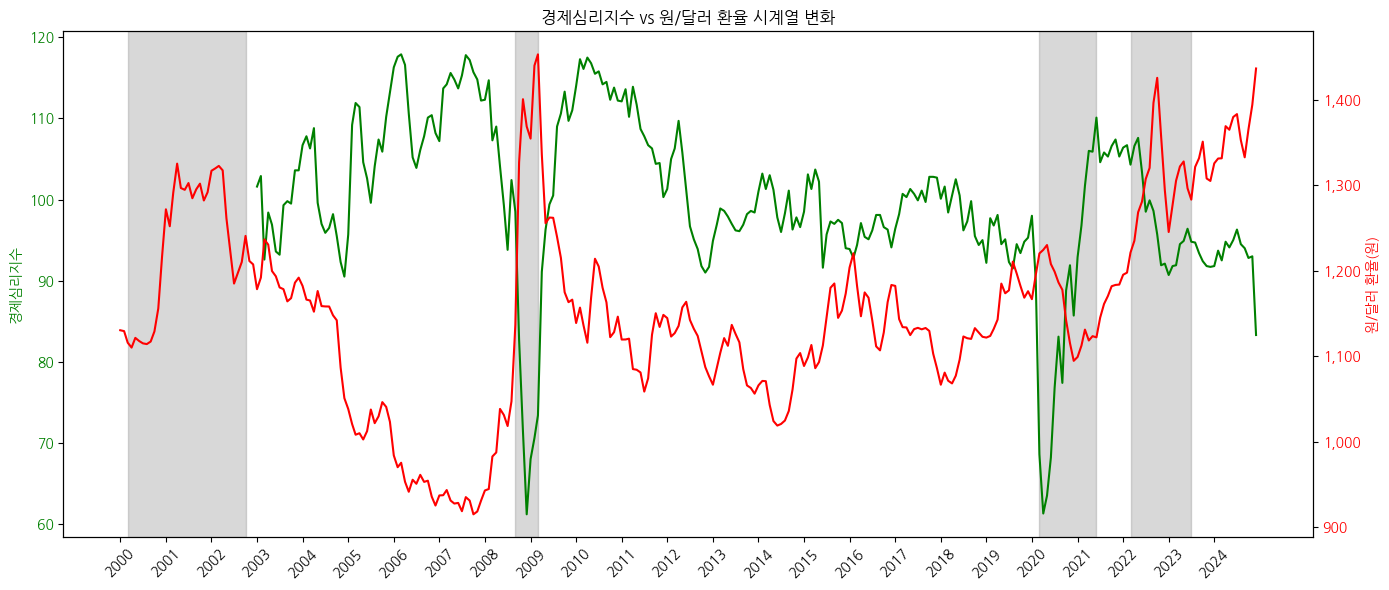

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# 이벤트 기간만 리스트로 설정
event_periods = [
    ('2000-03', '2002-10'),  # 닷컴 버블
    ('2008-09', '2009-03'),  # 글로벌 금융위기
    ('2020-03', '2021-06'),  # 코로나 팬데믹
    ('2022-03', '2023-07'),  # 자이언트 스텝
]

# 데이터 준비
df_plot = df.copy().reset_index()
df_plot["TIME"] = pd.to_datetime(df_plot["TIME"].astype(str))
df_plot["연도"] = df_plot["TIME"].dt.year

# x축 눈금
year_ticks = df_plot.groupby("연도")["TIME"].first().values
year_labels = df_plot["연도"].unique()

# 시각화
plt.figure(figsize=(14, 6))
ax1 = plt.gca()

# 경제심리지수
ax1.plot(df_plot["TIME"], df_plot["경제 심리 지수"], color="green", label="경제심리지수")
ax1.set_ylabel("경제심리지수", color="green")
ax1.tick_params(axis="y", labelcolor="green")

# 원/달러 환율
ax2 = ax1.twinx()
ax2.plot(df_plot["TIME"], df_plot["원/달러환율"], color="red", label="원/달러 환율")
ax2.set_ylabel("원/달러 환율(원)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

# 회색 음영으로 이벤트 기간 표시 (텍스트 없음)
for start, end in event_periods:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

# x축 설정
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(year_labels, rotation=45)

# 제목
plt.title("경제심리지수 vs 원/달러 환율 시계열 변화")
plt.tight_layout()
plt.show()

| 연도       | 주요 이벤트                     | 경제심리지수 반응      | 원/달러 환율 반응         |
|------------|----------------------------------|-------------------------|----------------------------|
| **2001**   | 9·11 테러                        | 급격한 심리 하락       | 환율 상승 (원화 약세)      |
| **2008~09**| 글로벌 금융위기                  | 급락                    | 급등 (1500원대 접근)       |
| **2010~12**| 유럽 재정위기                    | 불안정                  | 등락 (1100~1200원 사이)    |
| **2015~16**| 위안화 절하, 브렉시트(영국 유럽연합 탈퇴)           | 심리 약화               | 상승 (불안 심화)           |
| **2020**   | 코로나 팬데믹                    | 급락                    | 급등 (위기 시 원화 약세)   |
| **2022~23**| 美 기준금리 급등 (연준 긴축)     | 심리 위축 지속          | 1400원 돌파 (환율 급등)     |
| **2024**   | 긴축 완화 기대, 환율 안정 기조   | 반등 시도               | 완만한 하락세              |


[가설 1] 상관계수: -0.562, 양측 p-value: 0.0000


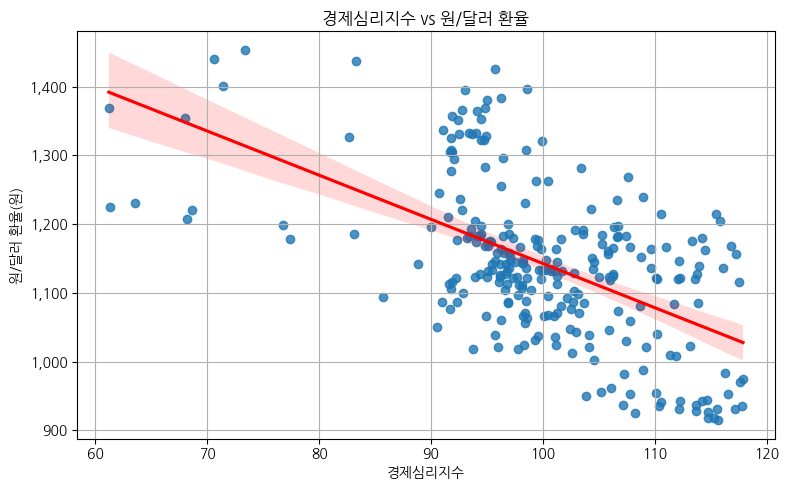

In [8]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 1. 데이터 전처리
subset = df[['경제 심리 지수', '원/달러환율']].dropna()
x = subset['경제 심리 지수']
y = subset['원/달러환율']

# 2. 피어슨 상관계수 (양측검정)
corr, pval = pearsonr(x, y)
print(f"[가설 1] 상관계수: {corr:.3f}, 양측 p-value: {pval:.4f}")

# 3. 산점도 + 회귀선 시각화
plt.figure(figsize=(8, 5))
sns.regplot(x=x, y=y, line_kws={"color": "red"})
plt.title("경제심리지수 vs 원/달러 환율")
plt.xlabel("경제심리지수")
plt.ylabel("원/달러 환율(원)")

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.grid(True)
plt.tight_layout()
plt.show()

### [가설 1] 추론통계 결과

- 상관계수:  - 0.562 **강한 음의 상관관계** 존재

- 단측 p-value: 0.00000

  → 강한 음의 상관관계 존재

  → p-value < 0.05로 통계적으로 유의미한 관계 확인됨

► 경제심리지수와 원/달러 환율 간의 상관계수는** -0.562**로,
경제심리가 악화될수록 환율이 상승하는 강한 음의 상관관계가 확인되었다.

또한 **p-value는 0.0000**으로, 해당 관계는 통계적으로도 매우 유의미하였다.
이는 경제 불안 상황에서 안전자산인 달러에 대한 수요가 증가하며,

심리적 요인이 환율 상승의 선행지표로 작용할 수 있음을 시사한다.

## **[가설2-1] 한미 금리차가 커질수록 외국인 투자금액은 증가할 것이다.**

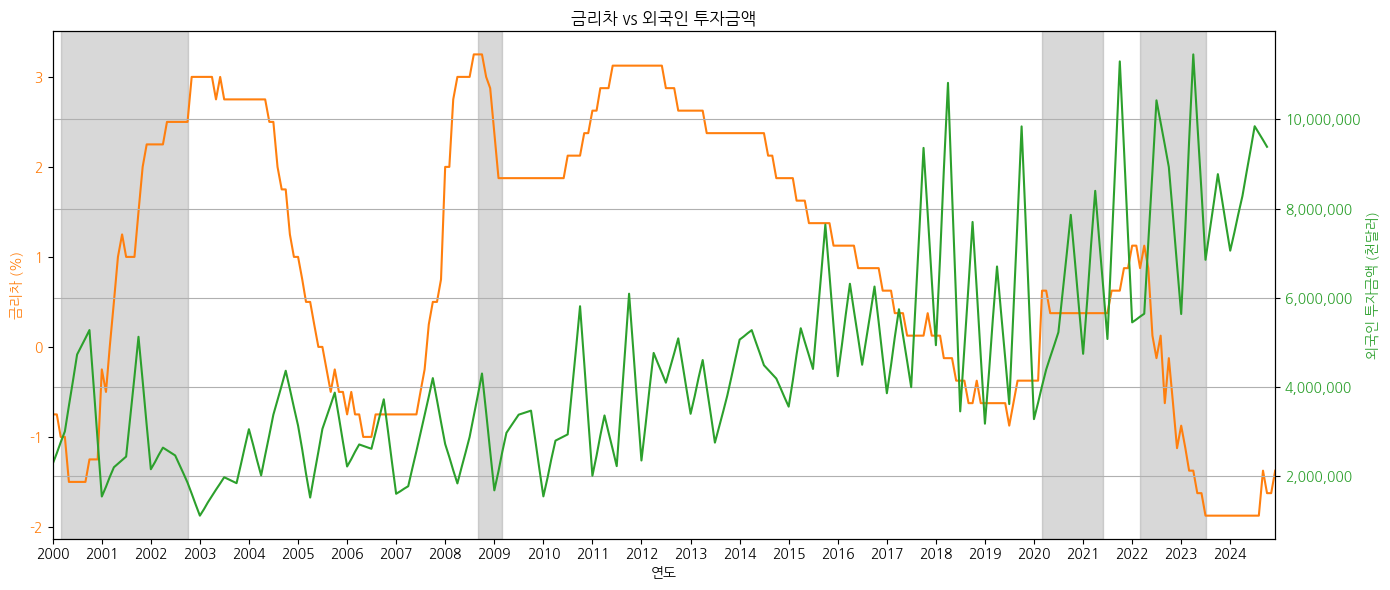

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd

# TIME 컬럼을 datetime으로 변환
df['TIME'] = pd.to_datetime(df['TIME'])

# 금리차 계산
df['금리차'] = df['한국 기준 금리'] - df['미국 기준 금리']

# 그래프 스타일 설정
fig, ax1 = plt.subplots(figsize=(14, 6))

# 금리차 - 왼쪽 y축
color1 = 'tab:orange'
ax1.set_xlabel('연도')
ax1.set_ylabel('금리차 (%)', color=color1)
ax1.plot(df['TIME'], df['금리차'], color=color1, label='금리차')
ax1.tick_params(axis='y', labelcolor=color1)

# x축 설정: 연도 단위로 간격 맞추기
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)
ax1.set_xlim([df['TIME'].min(), df['TIME'].max()])

# 외국인 투자금액 - 오른쪽 y축
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('외국인 투자금액 (천달러)', color=color2)
ax2.plot(df['TIME'], df['외국인 투자 금액'], color=color2, label='외국인 투자금액')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

# 🎯 이벤트 기간 회색 음영 표시
event_periods = [
    ('2000-03', '2002-10'),
    ('2008-09', '2009-03'),
    ('2020-03', '2021-06'),
    ('2022-03', '2023-07')
]

for start, end in event_periods:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    ax1.axvspan(mdates.date2num(start_date), mdates.date2num(end_date), color='gray', alpha=0.3)

# 제목 및 레이아웃
plt.title('금리차 vs 외국인 투자금액')
fig.tight_layout()
plt.grid(True)
plt.show()

### **[가설 2-1] 시계열 결론**

* 처음 가정: "경제심리가 나빠지면 외자 유입이 줄어들 것"

  → 데이터 상 부분적으로 타당

* 예외 발견: "심리 나쁜데도 외국인 투자가 늘어난 시기 존재 (2022~2023)"

  → 고금리/고환율의 수익 기회가 심리보다 더 큰 유인이 됨

* 가설 확장 필요성: "외국인 투자는 경제심리 외에도 금리차, 환율 등 구조적 변수의 영향을 동시에 받는다"

  → 그러나 금리차는 실제로도 외국인 투자를 설명하지 못했음 (오히려 상관관계는 음의 방향)

<br>
► 경제심리지수와 외국인 투자금액은 약한 음의 상관관계를 보이며, 일부 시기에는 심리 불안이 외자 이탈과 함께 발생했다.

그러나 전체적으로는 경제심리와 외국인 투자 사이의 직접적인 연관성은 약하며,

금리차와의 관계에서는 오히려 음의 상관관계가 나타나,

기존의 "금리차 확대 → 외자 유입" 가설과는 반대되는 흐름을 보였다.

이에 따라 외국인 자금 유입은 금리나 심리뿐만 아니라 다른 요인, 예컨대 환율 수준이나 글로벌 유동성 여건 등의 복합적 영향을 받을 수 있음을 시사한다.

In [16]:
corr_1 = df[["금리차", "외국인 투자 금액"]].corr().iloc[0, 1]
print(f"외국인 투자 금액과 금리차 간 상관계수: {corr_1:.3f}")

외국인 투자 금액과 금리차 간 상관계수: -0.475


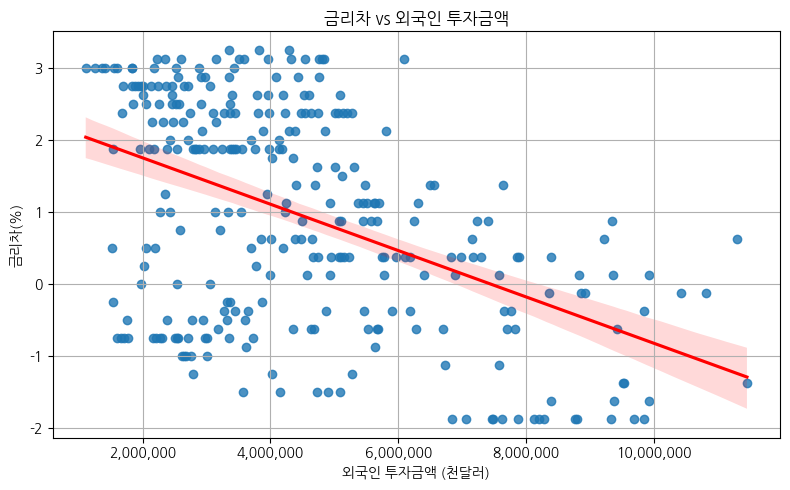

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 필요한 변수만 추
subset = df[['금리차', '외국인 투자 금액']].dropna()

plt.figure(figsize=(8, 5))
sns.regplot(x='외국인 투자 금액', y='금리차', data=subset, line_kws={"color": "red"})

# 축 단위 일반 숫자로 표시 (지수 형식 제거)
plt.ticklabel_format(style='plain', axis='y')

# 그래프 제목 및 축 이름
plt.title("금리차 vs 외국인 투자금액")
plt.xlabel("외국인 투자금액 (천달러)")
plt.ylabel("금리차(%)")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.grid(True)
plt.tight_layout()
plt.show()

### **[가설 2-1] 결론**

* 처음 가정: "경제심리가 나빠지면 외자 유입이 줄어들 것"

  → 데이터 상 부분적으로 타당

* 예외 발견: "심리 나쁜데도 외국인 투자가 늘어난 시기 존재 (2022~2023)"

  → 고금리/고환율의 수익 기회가 심리보다 더 큰 유인이 됨

* 가설 확장 필요성: "외국인 투자는 경제심리 외에도 금리차, 환율 등 구조적 변수의 영향을 동시에 받는다"

  → 그러나 금리차는 실제로도 외국인 투자를 설명하지 못했음 (오히려 상관관계는 음의 방향)

<br>
► 경제심리지수와 외국인 투자금액은 약한 음의 상관관계를 보이며, 일부 시기에는 심리 불안이 외자 이탈과 함께 발생했다.

그러나 전체적으로는 경제심리와 외국인 투자 사이의 직접적인 연관성은 약하며,

금리차와의 관계에서는 오히려 음의 상관관계가 나타나,

기존의 "금리차 확대 → 외자 유입" 가설과는 반대되는 흐름을 보였다.

이에 따라 외국인 자금 유입은 금리나 심리뿐만 아니라 다른 요인, 예컨대 환율 수준이나 글로벌 유동성 여건 등의 복합적 영향을 받을 수 있음을 시사한다.

## **[가설 2-2] 원/달러 환율이 상승하면 외국인 투자금액은 증가할 것이다.**

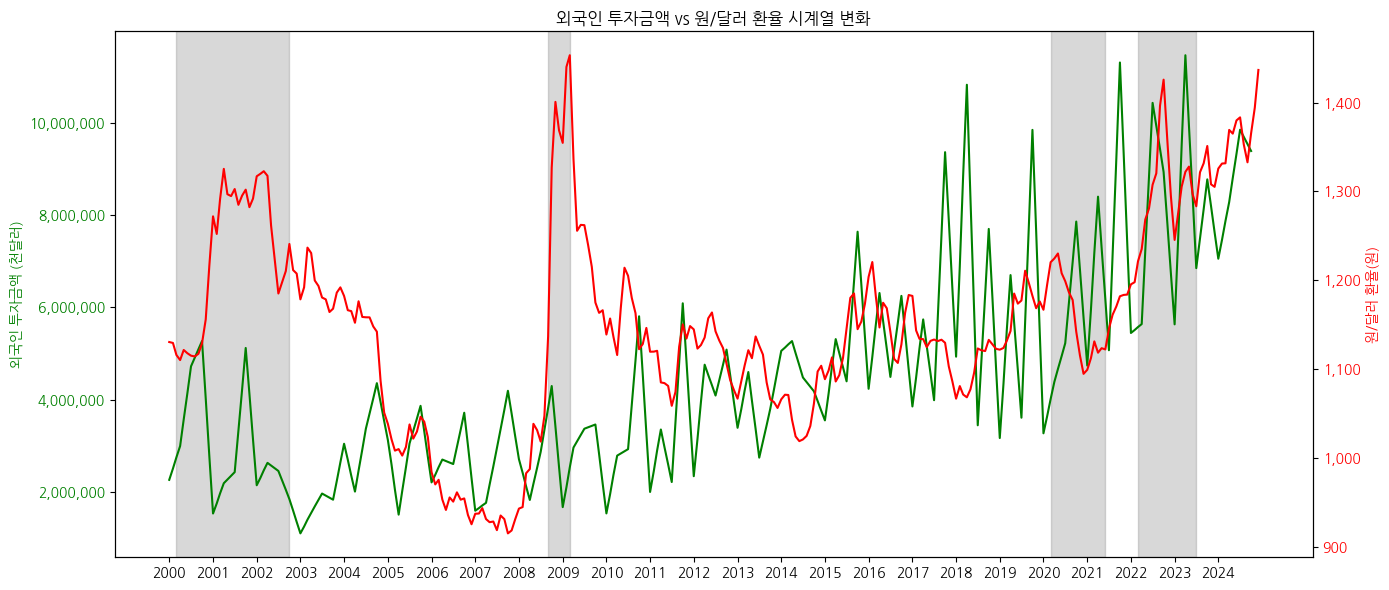

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# 데이터프레임 복사 및 시간 처리
df_plot = df.copy()
df_plot = df_plot.reset_index()
df_plot["TIME"] = pd.to_datetime(df_plot["TIME"])
df_plot["연도"] = df_plot["TIME"].dt.year
year_ticks = df_plot.groupby("연도")["TIME"].first().values
year_labels = df_plot["연도"].unique()

# 시각화
fig, ax1 = plt.subplots(figsize=(14, 6))

# 축 1: 외국인 투자금액
ax1.plot(df_plot["TIME"], df_plot["외국인 투자 금액"], color="green", label="외국인 투자금액")
ax1.set_ylabel("외국인 투자금액 (천달러)", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

# 축 2: 원/달러 환율
ax2 = ax1.twinx()
ax2.plot(df_plot["TIME"], df_plot["원/달러환율"], color="red", label="원/달러 환율")
ax2.set_ylabel("원/달러 환율(원)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

# 📌 이벤트 기간 회색 음영 표시
event_periods = [
    ('2000-03', '2002-10'),  # 닷컴 버블
    ('2008-09', '2009-03'),  # 글로벌 금융 위기
    ('2020-03', '2021-06'),  # 코로나 팬데믹
    ('2022-03', '2023-07'),  # 자이언트 스텝
]

for start, end in event_periods:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

# x축 연도 설정
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(year_labels, rotation=0)

# 제목 및 레이아웃
plt.title("외국인 투자금액 vs 원/달러 환율 시계열 변화")
plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import pearsonr
# 필요한 컬럼 정리
subset = df[['원/달러환율', '외국인 투자 금액']].dropna()
x = subset['외국인 투자 금액']
y = subset['원/달러환율']

# 상관계수 계산
corr, pval = pearsonr(x, y)
print(f"상관계수: {corr:.3f}, 양측 p-value: {pval:.4f}")

상관계수: 0.344, 양측 p-value: 0.0000


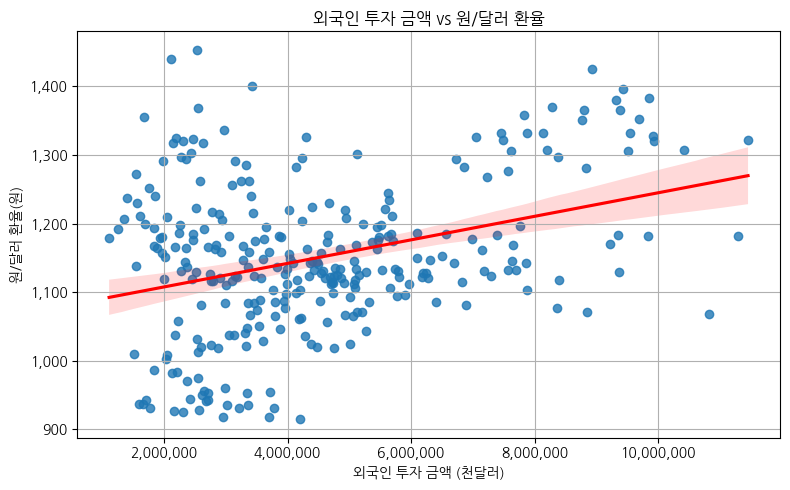

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 시각화
plt.figure(figsize=(8, 5))
sns.regplot(x=x, y=y, line_kws={"color": "red"})
plt.title("외국인 투자 금액 vs 원/달러 환율")
plt.xlabel("외국인 투자 금액 (천달러)")
plt.ylabel("원/달러 환율(원)")

# 축 단위 일반 표기로 변경
plt.ticklabel_format(style='plain', axis='x')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.grid(True)
plt.tight_layout()
plt.show()

##  **[가설 6] 외국인 투자금액이 늘면 외환보유액 변화량도 증가할 것이다.**


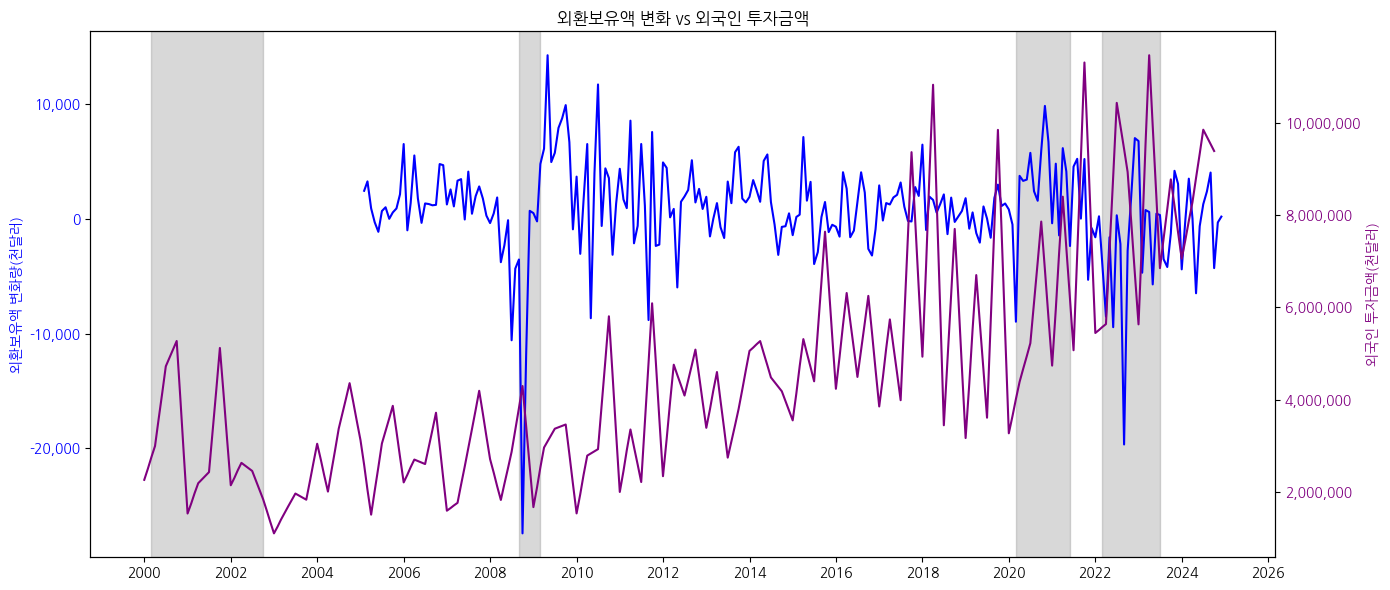

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pandas as pd

# 외환보유액 변화량 계산
df['외환보유액_변화'] = df['한국 외환 보유액'].diff()
df['TIME'] = pd.to_datetime(df['TIME'])

# 시각화
fig, ax3 = plt.subplots(figsize=(14, 6))

# 좌측: 외환보유액 변화량
ax3.plot(df['TIME'], df['외환보유액_변화'], color='blue')
ax3.set_ylabel('외환보유액 변화량(천달러)', color='blue')
ax3.tick_params(axis='y', labelcolor='blue')
ax3.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

# 우측: 외국인 투자금액
ax3b = ax3.twinx()
ax3b.plot(df['TIME'], df['외국인 투자 금액'], color='purple')
ax3b.set_ylabel('외국인 투자금액(천달러)', color='purple')
ax3b.tick_params(axis='y', labelcolor='purple')
ax3b.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

# 🎯 이벤트 구간 회색 음영 추가
event_periods = [
    ('2000-03', '2002-10'),
    ('2008-09', '2009-03'),
    ('2020-03', '2021-06'),
    ('2022-03', '2023-07'),
]

for start, end in event_periods:
    ax3.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

# 제목 및 레이아웃
ax3.set_title('외환보유액 변화 vs 외국인 투자금액')
plt.tight_layout()
plt.show()


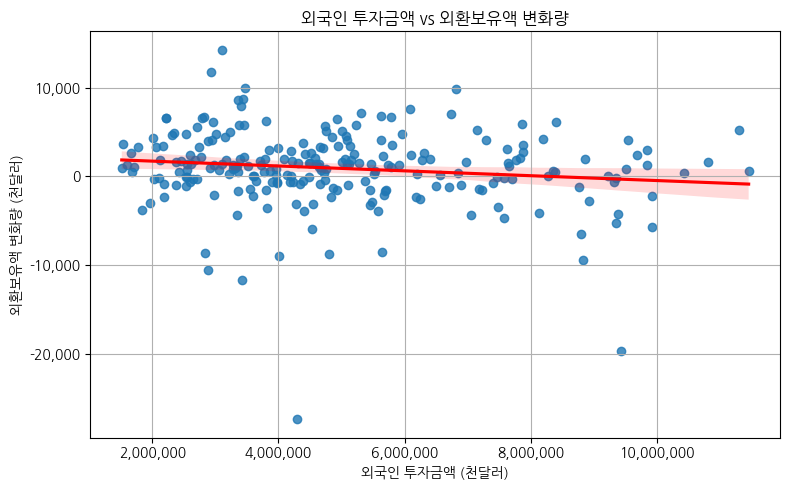

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 결측값 제거한 서브셋 생성
subset = df[['외국인 투자 금액', '외환보유액_변화']].dropna()

plt.figure(figsize=(8, 5))
sns.regplot(
    x='외국인 투자 금액',
    y='외환보유액_변화',
    data=subset,
    line_kws={"color": "red"}
)

# x축 단위 일반 숫자로 표시
plt.ticklabel_format(style='plain', axis='x')

# 제목 및 라벨 설정
plt.title("외국인 투자금액 vs 외환보유액 변화량")
plt.xlabel("외국인 투자금액 (천달러)")
plt.ylabel("외환보유액 변화량 (천달러)")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.grid(True)
plt.tight_layout()
plt.show()


► 가설은 통계적으로 유의하지만,

방향이 반대 → 외환보유액 증가는 외국인 자금 유입 외의 요인이 더 크게 작용함

" 외국인 투자금액이 늘면 외환보유액 변화량은 줄 수도 있다"

즉, 외국인 자금 유입은 단기 외환보유액 증대로 연결되기보다는,

정책적 방어, 환율 안정 개입, 자산 분산 등 다른 목적의 외화 사용과 함께 발생하며,

외환보유액 변화량을 직접 설명하기에는 한계가 있음을 시사한다.

## **[가설7] 경상수지가 흑자일수록 외환보유액 변화량은 증가할 것이다.**

[가설 7] 외환보유액 변화 vs 경상수지 상관계수: 0.026


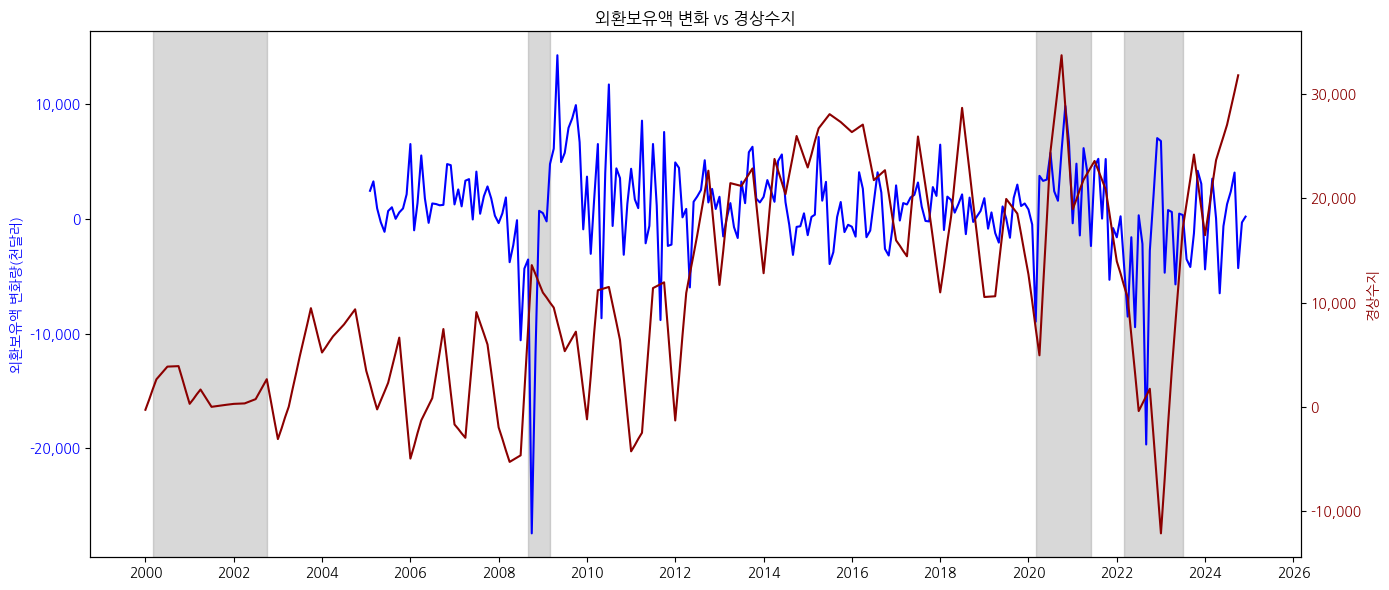

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# 상관계수 계산
corr_g7 = df[["한국 경상수지", "외환보유액_변화"]].corr().iloc[0, 1]
print(f"[가설 7] 외환보유액 변화 vs 경상수지 상관계수: {corr_g7:.3f}")

# 시계열 시각화
fig, ax1 = plt.subplots(figsize=(14, 6))

# 좌측 축: 외환보유액 변화량
ax1.plot(df['TIME'], df["외환보유액_변화"], color='blue', label='외환보유액 변화량')
ax1.set_ylabel('외환보유액 변화량(천달러)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))  # 천단위 콤마

# x축 설정
ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 우측 축: 경상수지
ax2 = ax1.twinx()
ax2.plot(df['TIME'], df["한국 경상수지"], color='darkred', label='경상수지')
ax2.set_ylabel('경상수지', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))  # 천단위 콤마

# 🎯 이벤트 구간 회색 음영 추가
event_periods = [
    ('2000-03', '2002-10'),  # 닷컴 버블
    ('2008-09', '2009-03'),  # 글로벌 금융 위기
    ('2020-03', '2021-06'),  # 코로나 팬데믹
    ('2022-03', '2023-07'),  # 자이언트 스텝
]

for start, end in event_periods:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

# 제목 및 레이아웃
plt.title("외환보유액 변화 vs 경상수지")
plt.tight_layout()
plt.show()

[가설 7] 상관계수: 0.026, 양측 p-value: 0.6906


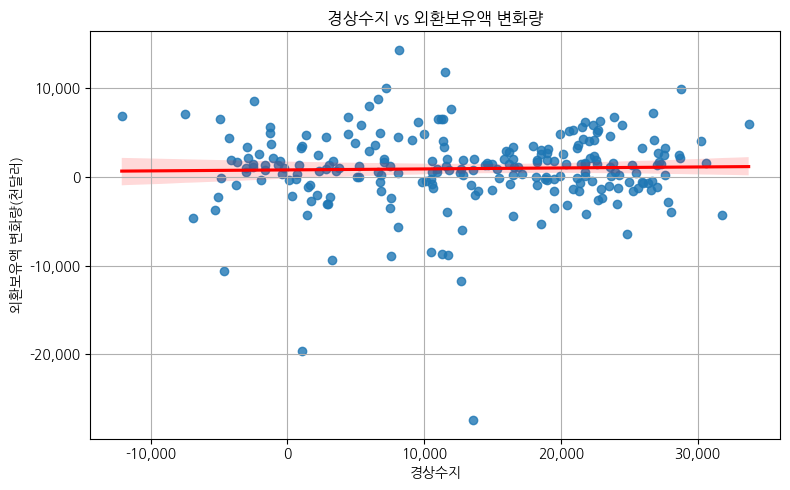

In [27]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# 분석용 변수 선택
subset = df[['한국 경상수지', '외환보유액_변화']].dropna()
x = subset['한국 경상수지']
y = subset['외환보유액_변화']

# 상관계수 및 p-value 계산 (양측)
corr, pval = pearsonr(x, y)
print(f"[가설 7] 상관계수: {corr:.3f}, 양측 p-value: {pval:.4f}")

# 시각화
plt.figure(figsize=(8, 5))
sns.regplot(x=x, y=y, line_kws={"color": "red"})
plt.title("경상수지 vs 외환보유액 변화량")
plt.xlabel("경상수지")
plt.ylabel("외환보유액 변화량(천달러)")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.grid(True)
plt.tight_layout()
plt.show()

► 경상수지 흑자가 곧 외환보유액 증가로 이어지는 직접적 연관성은 확인되지 않았으며,
외환보유액의 변화는 무역흑자 외에도 환율 개입, 외자 유출입, 평가손익 등 복합적인 요인의 영향을 받는 것으로 해석할 수 있다.

외환보유액의 증가가 투자와 관련이 없어 경상수지와 분석했으나 기대와 달리 유의미한 관계가 없었다

## **[가설4] 외환보유액 변화량이 증가할수록 원/달러 환율은 하락할 것이다.**

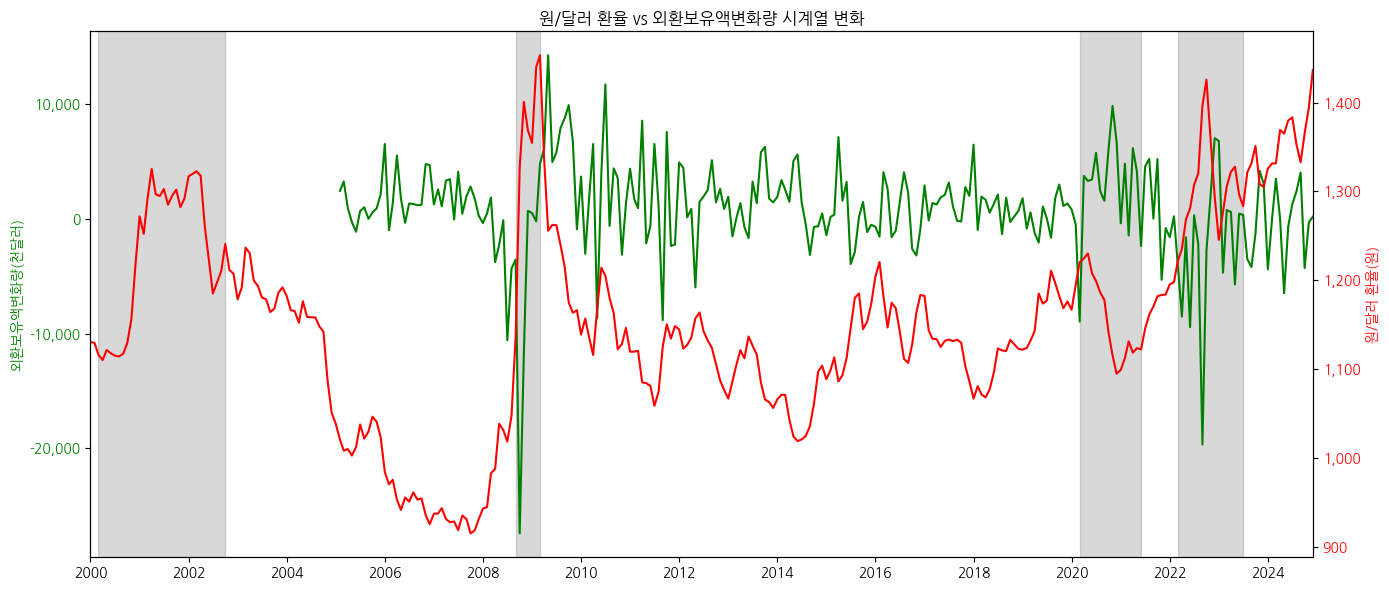

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import FuncFormatter

# ✅ 이벤트 기간만 설정 (라벨 없음)
event_periods = [
    ('2000-03', '2002-10'),  # 닷컴 버블
    ('2008-09', '2009-03'),  # 글로벌 금융위기
    ('2020-03', '2021-06'),  # 코로나 팬데믹
    ('2022-03', '2023-07'),  # 자이언트 스텝
]

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(14, 6))

# 왼쪽 축: 외환보유액 변화량
ax1.plot(df['TIME'], df['외환보유액_변화'], color='green', label='외환보유액변화량(천달러)')
ax1.set_ylabel('외환보유액변화량(천달러)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

# 오른쪽 축: 원/달러 환율
ax2 = ax1.twinx()
ax2.plot(df['TIME'], df['원/달러환율'], color='red', label='원/달러환율')
ax2.set_ylabel('원/달러 환율(원)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

# 🎯 회색 음영만 표시
for start, end in event_periods:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3)

# x축 설정
ax1.set_xlim([df['TIME'].min(), df['TIME'].max()])
ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 제목
plt.title("원/달러 환율 vs 외환보유액변화량 시계열 변화")
plt.tight_layout()
plt.show()


[가설 4] 상관계수: -0.205, 양측 p-value: 0.0014


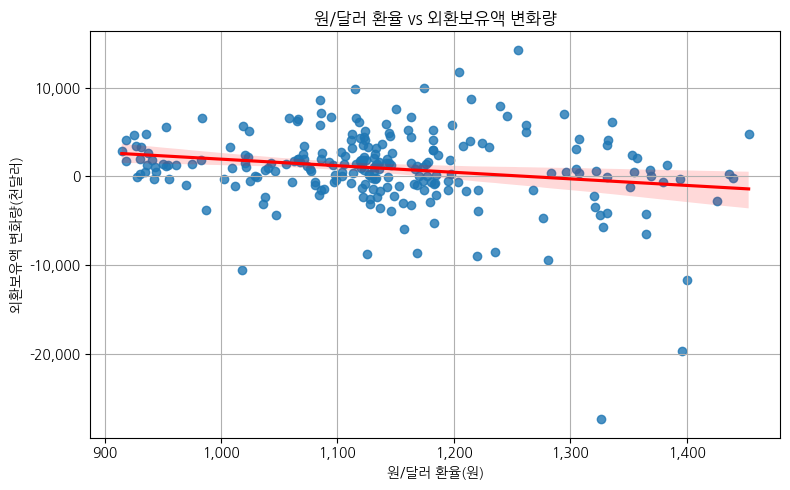

In [28]:
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 분석에 필요한 변수: 외환보유액 변화량, 원/달러 환율
subset = df[['외환보유액_변화', '원/달러환율']].dropna()
x = subset['원/달러환율']
y = subset['외환보유액_변화']

# 피어슨 상관계수 및 양측 p-value 계산
corr, pval = pearsonr(x, y)
print(f"[가설 4] 상관계수: {corr:.3f}, 양측 p-value: {pval:.4f}")

# 시각화
plt.figure(figsize=(8, 5))
sns.regplot(x=x, y=y, line_kws={"color": "red"})
plt.title("원/달러 환율 vs 외환보유액 변화량")
plt.xlabel("원/달러 환율(원)")
plt.ylabel("외환보유액 변화량(천달러)")
plt.grid(True)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
plt.tight_layout()
plt.show()

 ► 이는 외환보유액이 증가할 경우 원화가 강세를 보이며 환율이 하락하는 경향이 있음을 시사한다.
다만 상관계수의 절댓값이 크지 않아, 영향력은 제한적으로 해석된다.

또한 시각적으로 살펴보면, 외환보유액이 크게 감소하는 시기에는 환율이 급등하는 경향이 일부 나타났으며,
이는 외환보유액이 환율 방어 수단으로 작동하고 있음을 보여주는 지표로 볼 수 있다.

# [추가프로젝트] 위기 클러스터링 활용 대응 방안 제안

In [39]:
# 1. 데이터 로드 및 보간
df = df.interpolate(method='linear')
df = df.fillna(method='ffill').fillna(method='bfill')

<ipython-input-39-a8a633bef2ea>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


## 유의미한 소수기반 피처

In [40]:
# 유의미한 변수
selected_features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
                        'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
                        '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
                        '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
                        '외국인 투자 금액']

### 변화량 중심으로 피처 생성

In [41]:
# 1. 변화량(diff) 적용
X_diff = df[selected_features].diff().dropna()

# 2. 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_diff)

# 3. 클러스터링
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled)

# 4. 결과 추가 (dropna된 X_diff의 인덱스를 사용)
df_diff = df.loc[X_diff.index].copy()
df_diff['Cluster'] = clusters

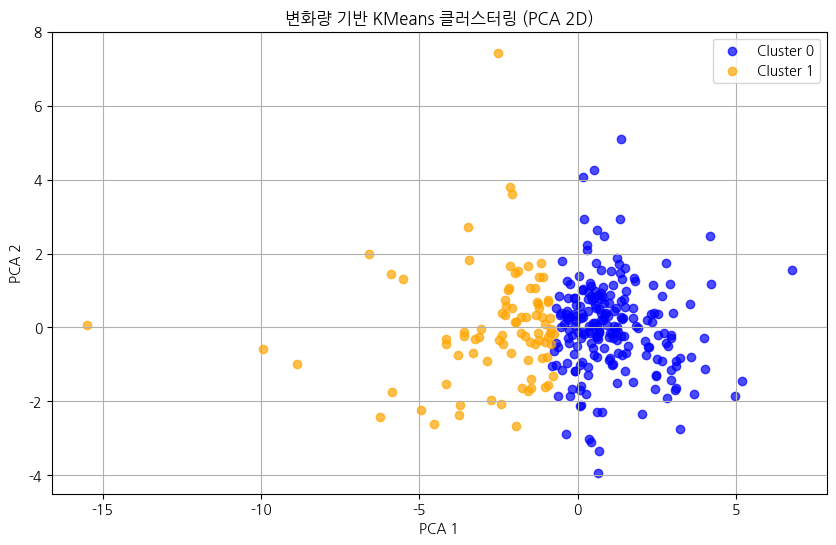

In [42]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. PCA로 2D 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. 시각화 데이터프레임 준비
df_plot = df_diff.copy()
df_plot['PCA1'] = X_pca[:, 0]
df_plot['PCA2'] = X_pca[:, 1]


# 시각화
plt.figure(figsize=(10, 6))

colors = {0: 'blue', 1: 'orange'}
for cluster_label in df_plot['Cluster'].unique():
    subset = df_plot[df_plot['Cluster'] == cluster_label]
    plt.scatter(subset['PCA1'], subset['PCA2'],
                label=f'Cluster {cluster_label}', alpha=0.7, c=colors[cluster_label])

plt.title('변화량 기반 KMeans 클러스터링 (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

* 유의미한 피처들로 클러스터링 했을 떄


| 이벤트           | 기간                          | 총 관측치 수 | Cluster 0 수 | Cluster 0 비율 |
|------------------|-------------------------------|--------------|----------------|-----------------|
| 닷컴 버블        | 2000-03-01 ~ 2002-10-31       | 32           | 25             | 0.78            |
| 글로벌 금융위기  | 2008-09-01 ~ 2009-03-31       | 7            | 2              | 0.29            |
| 코로나 팬데믹    | 2020-03-01 ~ 2021-06-30       | 16           | 13             | 0.81            |
| 자이언트 스텝    | 2022-03-01 ~ 2023-07-31       | 17           | 7              | 0.41            |


| 이벤트          | Cluster 0 비율 | 해석                                   |
| ------------ | ------------ | ------------------------------------ |
| **닷컴 버블**    | **0.78**     | ✔️ 대부분의 시점에서 불안정한 변화 감지 (위기 잘 포착)    |
| **글로벌 금융위기** | **0.29**     | ⚠️ 일부만 감지됨 (짧은 기간, 위기 반영이 약함)        |
| **코로나 팬데믹**  | **0.81**     | ✔️ 매우 높은 비율, 패닉적 변화 잘 포착             |
| **자이언트 스텝**  | **0.41**     | ⚠️ 반반 정도 포착 (시장 충격이 점진적이었던 영향일 수 있음) |

      [결과]

      Cluster 0은 크고 급격한 변화량이 발생하는 불안정 구간을 잘 잡고 있음.
      특히 닷컴 버블, 코로나 팬데믹은 높은 비율로 잘 포착됨.
      금융위기, 자이언트스텝은 일부 구간만 잡힘 → 구조적으로 짧거나 변동성이 일정한 패턴일 수도 있음.
      → 이건 변화량 기준 클러스터링의 한계 또는 시장 반응의 완화로 해석 가능


► Cluster 0은 변화량이 큰 불안정 구간을 대표하며,
특히 닷컴 버블(78%)과 코로나 팬데믹(81%) 시기에는 높은 비율로 등장해 급변하는 경제 환경을 민감하게 포착했다.

반면, 금융위기(29%)와 자이언트 스텝(41%)에서는 일부만 감지되어, 점진적 변화나 정책 개입 영향으로 변화량이 상대적으로 덜 표현된 것으로 해석할 수 있다.

### 유의미한 소수 피처 기반 p-value 검정 코드 유의성검정

- t-test p-value < 0.05 또는 Mann-Whitney p-value < 0.05이면 유의미한 차이

- Cluster 0의 평균이 **더 나쁘다 (감소 or 증가)**면 → 해당 변수는 위기 구간에서 민감하게 반응한 지표

In [43]:
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# selected_features: 소수 변수 리스트
selected_features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
                     'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
                     '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
                     '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
                     '외국인 투자 금액']

# df_diff: 변화량 + 클러스터 정보 포함된 데이터프레임
# 'Cluster' 컬럼: 0 or 1

def compare_clusters(df, selected_features):
    results = []

    for col in selected_features:
        # 1. 각 변수별로 클러스터 0과 1값 분리
        group_0 = df[df['Cluster'] == 0][col].dropna()
        group_1 = df[df['Cluster'] == 1][col].dropna()

        # 2. 두 그룹간의 평균 차이가 유의한지 확인 (t-test)
        t_stat, t_p = ttest_ind(group_0, group_1, equal_var=False)

        # 비모수 검정 (Mann-Whitney U test)
        u_stat, u_p = mannwhitneyu(group_0, group_1, alternative='two-sided')

        #  정규성 가정이 어려운 경우를 대비한 비모수 검정 # 결과는 평균값, t-test, 비모수 검정의 p-value까지 모두 수록
        results.append({
            '변수': col,
            'Cluster 0 평균': group_0.mean(),
            'Cluster 1 평균': group_1.mean(),
            't-test p-value': round(t_p, 4),
            'Mann-Whitney p-value': round(u_p, 4)
        })

    return pd.DataFrame(results)

# 실행
result_small_features = compare_clusters(df_diff, selected_features)

# 결과 테이블 보기
pd.set_option('display.max_rows', None)  # 필요시 전체 행 보기
pd.set_option('display.max_columns', None)
display(result_small_features)

# 또는 간단히
# print(result_small_features)

,변수,Cluster 0 평균,Cluster 1 평균,t-test p-value,Mann-Whitney p-value
0,경제 심리 지수,1.011526e+02,9.779884e+01,0.0110,0.0135
1,한국 외환 보유액,3.058692e+05,3.330613e+05,0.0134,0.0243
2,vix,1.881254e+01,2.265116e+01,0.0017,0.0038
3,WTI 유가,6.199714e+01,6.825942e+01,0.0566,0.0538
4,한국 실업률,3.538967e+00,3.394186e+00,0.0104,0.0076
5,두바이 유가,6.196446e+01,7.091430e+01,0.0136,0.0160
6,Brent 유가,6.458606e+01,7.323663e+01,0.0194,0.0219
7,천연가스 가격,4.454460e+00,4.128605e+00,0.2065,0.3164
8,유연탄 가격,8.787277e+01,1.174856e+02,0.0088,0.0020
9,미국 주가지수,9.198216e+01,9.867326e+01,0.1260,0.0784


## 가설을 세운 모든 변수 기반 피처

In [44]:
# 변수 정의
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            'M2', '실질GDP성장률', 'vix']

### 변화량 중심으로 피처 생성

In [45]:
# 1. 변화량(diff) 적용
X_diff = df[features].diff().dropna()

# 2. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_diff)

# 3. 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 4. 클러스터 결과 추가
df_diff = df.loc[X_diff.index].copy()
df_diff['Cluster'] = clusters

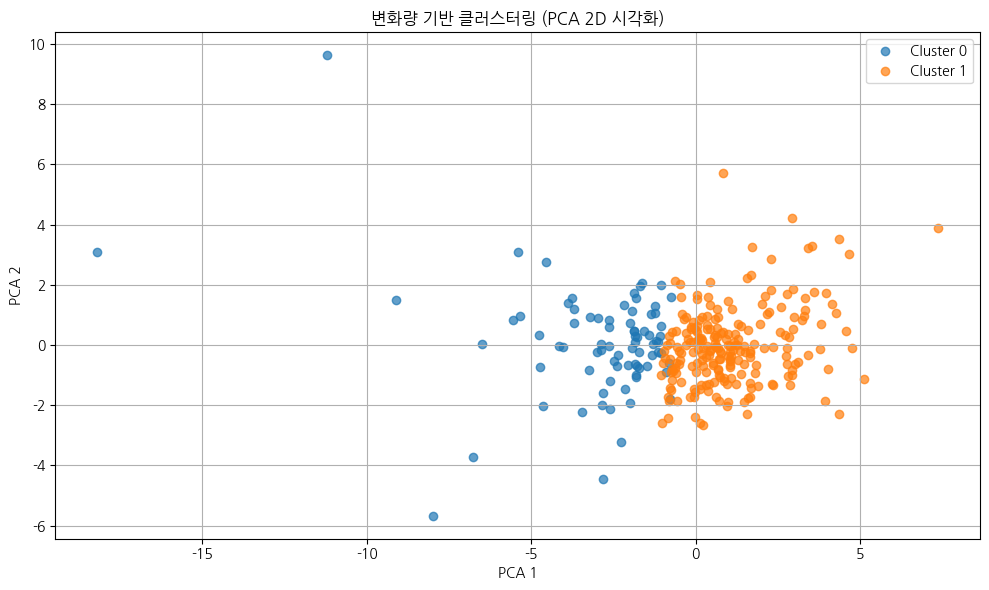

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 5. PCA로 2D 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 6. 결과 DataFrame에 PCA 결과 추가
df_diff['PCA1'] = X_pca[:, 0]
df_diff['PCA2'] = X_pca[:, 1]

# 7. 시각화
plt.figure(figsize=(10, 6))
colors = {0: 'tab:blue', 1: 'tab:orange'}

for cluster_label in sorted(df_diff['Cluster'].unique()):
    subset = df_diff[df_diff['Cluster'] == cluster_label]
    plt.scatter(subset['PCA1'], subset['PCA2'],
                label=f'Cluster {cluster_label}',
                alpha=0.7,
                color=colors[cluster_label])

plt.title('변화량 기반 클러스터링 (PCA 2D 시각화)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


| 이벤트           | 기간                          | 총 관측치 수 | Cluster 0 수 | Cluster 0 비율 |
|------------------|-------------------------------|--------------|----------------|-----------------|
| 닷컴 버블        | 2000-03-01 ~ 2002-10-31       | 32           | 6              | 0.19            |
| 글로벌 금융위기  | 2008-09-01 ~ 2009-03-31       | 7            | 5              | 0.71            |
| 코로나 팬데믹    | 2020-03-01 ~ 2021-06-30       | 16           | 2              | 0.12            |
| 자이언트 스텝    | 2022-03-01 ~ 2023-07-31       | 17           | 9              | 0.53            |




### 전체변수 피처 기반 p-value 검정 코드 유의성검정

In [47]:
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# 변수 정의
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            'M2', '실질GDP성장률', 'vix']

# df_diff: 변화량 + 클러스터 정보 포함된 데이터프레임
# 'Cluster' 컬럼: 0 or 1

def compare_clusters(df, features):
    results = []

    for col in features:
        # 1. 각 변수별로 클러스터 0과 1값 분리
        group_0 = df[df['Cluster'] == 0][col].dropna()
        group_1 = df[df['Cluster'] == 1][col].dropna()

        # 2. 두 그룹간의 평균 차이가 유의한지 확인 (t-test)
        t_stat, t_p = ttest_ind(group_0, group_1, equal_var=False)

        # 비모수 검정 (Mann-Whitney U test)
        u_stat, u_p = mannwhitneyu(group_0, group_1, alternative='two-sided')

        #  정규성 가정이 어려운 경우를 대비한 비모수 검정 # 결과는 평균값, t-test, 비모수 검정의 p-value까지 모두 수록
        results.append({
            '변수': col,
            'Cluster 0 평균': group_0.mean(),
            'Cluster 1 평균': group_1.mean(),
            't-test p-value': round(t_p, 4),
            'Mann-Whitney p-value': round(u_p, 4)
        })

    return pd.DataFrame(results)

# 실행
result_small_features = compare_clusters(df_diff, selected_features)

# 결과 테이블 보기
pd.set_option('display.max_rows', None)  # 필요시 전체 행 보기
pd.set_option('display.max_columns', None)
display(result_small_features)

# 또는 간단히
# print(result_small_features)

,변수,Cluster 0 평균,Cluster 1 평균,t-test p-value,Mann-Whitney p-value
0,경제 심리 지수,9.796329e+01,1.009868e+02,0.0286,0.0308
1,한국 외환 보유액,3.304112e+05,3.076860e+05,0.0438,0.0675
2,vix,2.320494e+01,1.873582e+01,0.0006,0.0006
3,WTI 유가,6.938076e+01,6.179373e+01,0.0249,0.0221
4,한국 실업률,3.374684e+00,3.541364e+00,0.0031,0.0034
5,두바이 유가,7.195038e+01,6.187718e+01,0.0069,0.0072
6,Brent 유가,7.437810e+01,6.445141e+01,0.0091,0.0095
7,천연가스 가격,4.240506e+00,4.403909e+00,0.5419,0.6821
8,유연탄 가격,1.206091e+02,8.769336e+01,0.0061,0.0011
9,미국 주가지수,9.795190e+01,9.245409e+01,0.2242,0.1784


## 두 결과 비교

| 이벤트      | 기존 클러스터링 (소수 변수) | 확장 변수 클러스터링 |
| -------- | ---------------- | ----------- |
| 닷컴 버블    | **0.78**         | **0.19**    |
| 글로벌 금융위기 | 0.29             | **0.71**    |
| 코로나 팬데믹  | **0.81**         | 0.12        |
| 자이언트 스텝  | 0.41             | **0.53**    |


소수 변수 기반 클러스터링은 감도 높고 날카롭게 일부 위기를 포착함 (ex. 코로나, 닷컴)

확장 변수 기반 클러스터링은 금융 시스템 전반의 충격이 반영된 위기 (글로벌 금융위기, 자이언트스텝)에 더 강함

즉,
감도 높은 조기 탐지는 소수 변수
전방위 충격 감지는 확장 변수
→ 둘을 보완적으로 활용할 수 있음

    두 클러스터링은 유사한 지표군을 기반으로 하지만,
    변수 구성의 폭과 강조점에서 차이를 보입니다.

    소수 변수 기반은 민감도(변화 감지 능력) 측면에서,
    확장 변수 기반은 종합성(다층적 변화 반영) 측면에서 강점을 보입니다.

## 결론 및 제안


| 이벤트           | 소수 클러스터 0 비율 | 확장 클러스터 0 비율 | 해석 방향       | 위기 유형 분류    |
|------------------|----------------------|-----------------------|------------------|-------------------|
| 닷컴 버블        | 0.78                 | 0.19                  | 심리적 반응 강함 | 📢 심리 기반 위기 |
| 글로벌 금융위기  | 0.29                 | 0.71                  | 구조 변화 강함   | 🏦 구조 기반 위기 |
| 코로나 팬데믹    | 0.81                 | 0.12                  | 급변한 심리 반응 | 📢 심리 기반 위기 |
| 자이언트 스텝    | 0.41                 | 0.53                  | 양쪽 모두 반응   | ⚠️ 복합 위기       |



| 위기 유형       | 경보 아이콘        | 메시지 예시                                                  |
| ----------- | ------------- | ------------------------------------------------------- |
| 📢 심리 기반 위기 | “시장 심리 불안 경보” | 금융시장 심리가 급변하고 있으며, 정책적 신뢰 회복이 중요합니다.                    |
| 🏦 구조 기반 위기 | “시스템 리스크 경보”  | 주요 거시지표의 구조적 변화가 감지되었습니다. 통화·재정정책의 공조 대응이 요구됩니다.        |
| ⚠️ 복합 위기    | “복합 위기 경보”    | 시장 심리와 경제 시스템 모두에서 이상 징후가 나타나고 있습니다. 전방위적 위기 대응이 필요합니다. |

| 기준                   | 소수 피처셋                   | 전체 피처셋             |
| -------------------- | ------------------------ | ------------------ |
| **패닉기 (VIX↑, GDP↓)** | **불명확** (VIX 낮거나 GDP 높음) | ✅ 명확히 포착           |
| **정책 대응 (M2↑, 금↑)**  | 부분 포착                    | ✅ 전체적으로 강하게 반영     |
| **시장 충격/자산 가격 반영**   | 유가, 외환 등 구조 반응만          | ✅ 금, 유연탄, 구리 등도 포함 |
| **심리지표 일관성**         | 높기도 하고 낮기도 함 (해석 혼란)     | ✅ 위기 구간에서 심리 하락 일관 |


<전체 피처셋>

**위기일수록 → GDP 성장률 ↓, 심리지수 ↓, 금 가격 ↑, M2 ↑, 실업률 ↑**

이건 거시경제 정책 반응이 따라붙는 **위기의 전형적 모습**

정책 결정자 입장에서 위기를 진단하는 데 필요한 지표들이 고루 반영됨

> 경제학적 정합성과 변수 간 해석 일관성을 기준으로 볼 때, 전체 피처셋 기반 클러스터링은 실질 GDP  성장률 하락, 금 가격 상승, 유동성 공급 확대 등 전형적인 위기 특성을 명확히 반영하고 있으며, 위기 탐지 성능 면에서 더 우수하다. 반면 소수 피처셋은 변화량에 민감한 구조를 통해 조기 경보 기능은 제공하나, 거시경제적 위기의 구조적 특성을 포착하는 데에는 한계가 있다.

# GRU 머신러닝 (채택된 성능 좋은 머신러닝)

**비교 피처셋**

- 전체변수 : L1 + 단계
- 통계적으로 유의미한 변수 : L1 + 단계

In [49]:
import random
import numpy as np
import tensorflow as tf
import os

def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## 전체변수

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

set_seed(50)

# Feature 및 Target 설정
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            '실질GDP', '실질GDP성장률', 'vix']
target = '원/달러환율'

# 데이터 준비
X = df[features].fillna(method='ffill').fillna(method='bfill')
y = df[target].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

# 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# 시퀀스 생성
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# GRU 학습 및 평가
def train_gru(X_train_sel, X_test_sel, l1_value=0.0, l2_value=0.0):
    X_train_seq, y_train_seq = create_sequences(X_train_sel, y_train_scaled)
    X_test_seq, y_test_seq = create_sequences(X_test_sel, y_test_scaled)

    model = Sequential()
    model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                  kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)))
    model.add(GRU(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
              callbacks=[early_stop], verbose=0)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    return rmse, mae, r2, y_test_actual, y_pred

# L1, L2 설정
l1_values = [0.0, 0.001, 0.01]
l2_values = [0.0, 0.001, 0.01]

# 결과 저장
all_results = []
y_test_actual_best = None
y_pred_best = None

# 선택법별 loop
for method_name, selector in [
    ("전진 선택법", SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='forward')),
    ("후진 선택법", SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='backward')),
    ("단계적 선택법", SFS(LinearRegression(), k_features='best', forward=True, floating=True, scoring='r2', cv=0))
]:
    if method_name == "단계적 선택법":
        selector = selector.fit(X_train_scaled, y_train_scaled.ravel())
        selected_idx = list(selector.k_feature_idx_)
    else:
        selector = selector.fit(X_train_scaled, y_train_scaled.ravel())
        selected_idx = selector.get_support(indices=True)

    selected_features = np.array(features)[selected_idx]
    print(f"\n✅ {method_name} 선택된 feature: {selected_features}")

    X_train_sel = X_train_scaled[:, selected_idx]
    X_test_sel = X_test_scaled[:, selected_idx]

    for l1 in l1_values:
        for l2 in l2_values:
            rmse, mae, r2, y_actual, y_pred = train_gru(X_train_sel, X_test_sel, l1, l2)

            # 전진 선택법 + L1=0.0 + L2=0.0일 경우 시각화용 값 저장
            if method_name == "전진 선택법" and l1 == 0.0 and l2 == 0.0:
                y_test_actual_best = y_actual
                y_pred_best = y_pred

            all_results.append({
                'Method': method_name,
                'L1': l1,
                'L2': l2,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            print(f"→ L1: {l1}, L2: {l2} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

# 결과 정리
results_df = pd.DataFrame(all_results)
print("\n=== 전체 결과 (RMSE 기준 정렬) ===")
print(results_df.sort_values(by='RMSE'))

<ipython-input-64-27880fb3d059>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df[features].fillna(method='ffill').fillna(method='bfill')



✅ 전진 선택법 선택된 feature: ['경제 심리 지수' '한국 기준 금리' '두바이 유가' 'Brent 유가' '천연가스 가격' '철광석 가격' '구리 가격'
 '알루미늄 가격' '니켈 가격' '외국인 투자 금액' '소맥 가격' '원당 가격' '한국 경상수지' '한국 인플레이션율' 'vix']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 145.8452, MAE: 132.8086, R^2: -1.5080


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 140.5519, MAE: 129.0134, R^2: -1.3293


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
→ L1: 0.0, L2: 0.01 → RMSE: 132.9348, MAE: 116.4993, R^2: -1.0837


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
→ L1: 0.001, L2: 0.0 → RMSE: 141.3606, MAE: 121.2118, R^2: -1.3562


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 141.7545, MAE: 125.3867, R^2: -1.3693


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 136.2836, MAE: 119.1527, R^2: -1.1900


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 124.3600, MAE: 108.3785, R^2: -0.8235


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 125.8130, MAE: 107.5145, R^2: -0.8664


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 111.0281, MAE: 96.9337, R^2: -0.4535

✅ 후진 선택법 선택된 feature: ['경제 심리 지수' '한국 외환 보유액' '미국 실업률' '미국 주가지수' '두바이 유가' 'Brent 유가' '천연가스 가격'
 '유연탄 가격' '철광석 가격' '알루미늄 가격' '니켈 가격' '옥수수 가격' '소맥 가격' '한국 경상수지'
 '한국 인플레이션율' 'vix']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 85.7869, MAE: 78.8372, R^2: 0.1323


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 102.6221, MAE: 84.8080, R^2: -0.2417


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
→ L1: 0.0, L2: 0.01 → RMSE: 114.7395, MAE: 89.8602, R^2: -0.5523


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
→ L1: 0.001, L2: 0.0 → RMSE: 70.5116, MAE: 53.8438, R^2: 0.4138


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 140.3027, MAE: 116.6203, R^2: -1.3210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 147.9904, MAE: 113.0248, R^2: -1.5824


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 96.7822, MAE: 78.8864, R^2: -0.1044


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 170.9831, MAE: 147.7707, R^2: -2.4471


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 93.7695, MAE: 78.9077, R^2: -0.0368

✅ 단계적 선택법 선택된 feature: ['경제 심리 지수' '한국 기준 금리' '미국 기준 금리' '한국 외환 보유액' '한국 실업률' '미국 실업률' '한국 주가지수'
 '미국 주가지수' 'WTI 유가' '두바이 유가' 'Brent 유가' '천연가스 가격' '유연탄 가격' '철광석 가격'
 '구리 가격' '알루미늄 가격' '니켈 가격' '아연 가격' '금 가격' '대두 가격' '외국인 투자 금액' '옥수수 가격'
 '소맥 가격' '원당 가격' '원면 가격' '한국 경상수지' '한국 인플레이션율' '인플레이션 격차' '실질GDP'
 '실질GDP성장률' 'vix']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 75.8802, MAE: 66.9470, R^2: 0.3211


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 123.3657, MAE: 102.7137, R^2: -0.7945


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
→ L1: 0.0, L2: 0.01 → RMSE: 101.7397, MAE: 82.5137, R^2: -0.2205


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
→ L1: 0.001, L2: 0.0 → RMSE: 100.1255, MAE: 81.9872, R^2: -0.1821


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 86.9224, MAE: 69.5813, R^2: 0.1091


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 85.4432, MAE: 68.8740, R^2: 0.1392


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 56.8256, MAE: 44.4941, R^2: 0.6192


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 66.9294, MAE: 53.8639, R^2: 0.4718


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 79.2582, MAE: 63.2198, R^2: 0.2593

=== 전체 결과 (RMSE 기준 정렬) ===
     Method     L1     L2        RMSE         MAE        R2
24  단계적 선택법  0.010  0.000   56.825642   44.494144  0.619250
25  단계적 선택법  0.010  0.001   66.929402   53.863873  0.471816
12   후진 선택법  0.001  0.000   70.511563   53.843845  0.413764
18  단계적 선택법  0.000  0.000   75.880164   66.947002  0.321097
26  단계적 선택법  0.010  0.010   79.258183   63.219823  0.259304
23  단계적 선택법  0.001  0.010   85.443249   68.874011  0.139191
9    후진 선택법  0.000  0.000   85.786871   78.837160  0.132253
22  단계적 선택법  0.001  0.001   86.922425   69.581272  0.109128
17   후진 선택법  0.010  0.010   93.769468   78.907669 -0.036751
15   후진 선택법  0.010  0.000   96.782167   78.886426 -0.104440
21  단계적 선택법  0.001  0.000  100.125467   81.987165 -0.182063
20  단계적 선택법  0.000  0.010  101.739709   82.513706 -0.220485
10   후진 선택법  0.000  0.001  102.622110   84.807953 -0.241748
8    전진 선택법  0.010  0.010  11

## 유의미한 변수

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

set_seed(50)

# Feature 및 Target 설정
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

# 데이터 준비
X = df[features].fillna(method='ffill').fillna(method='bfill')
y = df[target].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

# 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# 시퀀스 생성
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# GRU 학습 및 평가
def train_gru(X_train_sel, X_test_sel, l1_value=0.0, l2_value=0.0):
    X_train_seq, y_train_seq = create_sequences(X_train_sel, y_train_scaled)
    X_test_seq, y_test_seq = create_sequences(X_test_sel, y_test_scaled)

    model = Sequential()
    model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                  kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)))
    model.add(GRU(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_value, l2=l2_value)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
              callbacks=[early_stop], verbose=0)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)

    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    return rmse, mae, r2, y_test_actual, y_pred

# ✅ L1, L2 설정
l1_values = [0.0, 0.001, 0.01]
l2_values = [0.0, 0.001, 0.01]

# 결과 저장
all_results = []
y_test_actual_best = None
y_pred_best = None

# 선택법별 loop
for method_name, selector in [
    ("전진 선택법", SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='forward')),
    ("후진 선택법", SequentialFeatureSelector(LinearRegression(), n_features_to_select='auto', direction='backward')),
    ("단계적 선택법", SFS(LinearRegression(), k_features='best', forward=True, floating=True, scoring='r2', cv=0))
]:
    if method_name == "단계적 선택법":
        selector = selector.fit(X_train_scaled, y_train_scaled.ravel())
        selected_idx = list(selector.k_feature_idx_)
    else:
        selector = selector.fit(X_train_scaled, y_train_scaled.ravel())
        selected_idx = selector.get_support(indices=True)

    selected_features = np.array(features)[selected_idx]
    print(f"\n✅ {method_name} 선택된 feature: {selected_features}")

    X_train_sel = X_train_scaled[:, selected_idx]
    X_test_sel = X_test_scaled[:, selected_idx]

    for l1 in l1_values:
        for l2 in l2_values:
            rmse, mae, r2, y_actual, y_pred = train_gru(X_train_sel, X_test_sel, l1, l2)

            # 전진 선택법 + L1=0.0 + L2=0.0일 경우 시각화용 값 저장
            if method_name == "전진 선택법" and l1 == 0.0 and l2 == 0.0:
                y_test_actual_best = y_actual
                y_pred_best = y_pred

            all_results.append({
                'Method': method_name,
                'L1': l1,
                'L2': l2,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            })
            print(f"→ L1: {l1}, L2: {l2} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")

# 결과 정리
results_df = pd.DataFrame(all_results)
print("\n=== 전체 결과 (RMSE 기준 정렬) ===")
print(results_df.sort_values(by='RMSE'))

<ipython-input-65-51f8ab70fb78>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df[features].fillna(method='ffill').fillna(method='bfill')



✅ 전진 선택법 선택된 feature: ['경제 심리 지수' '한국 외환 보유액' 'vix' '천연가스 가격' '한국 인플레이션율' 'M2' '아연 가격' '알루미늄 가격'
 '니켈 가격' '외국인 투자 금액']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 389ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 78.6367, MAE: 65.7434, R^2: 0.2709


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 81.9590, MAE: 67.2501, R^2: 0.2080


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
→ L1: 0.0, L2: 0.01 → RMSE: 98.0150, MAE: 81.9350, R^2: -0.1328


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step
→ L1: 0.001, L2: 0.0 → RMSE: 105.2792, MAE: 88.0299, R^2: -0.3069


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 116.4832, MAE: 94.6820, R^2: -0.5998


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 91.8267, MAE: 76.8791, R^2: 0.0058


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 80.7368, MAE: 69.4086, R^2: 0.2314


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 83.9933, MAE: 66.9423, R^2: 0.1682


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 138.1436, MAE: 119.0348, R^2: -1.2502

✅ 후진 선택법 선택된 feature: ['한국 외환 보유액' 'vix' '두바이 유가' 'Brent 유가' '천연가스 가격' '유연탄 가격' '한국 인플레이션율'
 '금 가격' '알루미늄 가격' '니켈 가격']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 87.0764, MAE: 79.3338, R^2: 0.1060


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 498ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 114.3248, MAE: 90.7531, R^2: -0.5411


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
→ L1: 0.0, L2: 0.01 → RMSE: 118.5494, MAE: 91.3183, R^2: -0.6571


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
→ L1: 0.001, L2: 0.0 → RMSE: 120.6791, MAE: 95.8451, R^2: -0.7172


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 119.2190, MAE: 93.1423, R^2: -0.6759


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 110.9398, MAE: 85.5506, R^2: -0.4512


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 161.6954, MAE: 141.8309, R^2: -2.0828


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 91.9930, MAE: 75.9416, R^2: 0.0022


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 95.8801, MAE: 81.4574, R^2: -0.0839

✅ 단계적 선택법 선택된 feature: ['경제 심리 지수' '한국 외환 보유액' 'vix' 'WTI 유가' '한국 실업률' '두바이 유가' 'Brent 유가'
 '천연가스 가격' '유연탄 가격' '미국 주가지수' '한국 인플레이션율' '인플레이션 격차' '실질GDP성장률' 'M2'
 '금 가격' '구리 가격' '아연 가격' '알루미늄 가격' '니켈 가격' '외국인 투자 금액']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step
→ L1: 0.0, L2: 0.0 → RMSE: 93.4073, MAE: 81.6573, R^2: -0.0288


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
→ L1: 0.0, L2: 0.001 → RMSE: 146.0474, MAE: 122.5250, R^2: -1.5150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
→ L1: 0.0, L2: 0.01 → RMSE: 108.4895, MAE: 84.5396, R^2: -0.3878


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
→ L1: 0.001, L2: 0.0 → RMSE: 129.4871, MAE: 109.5533, R^2: -0.9770


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step
→ L1: 0.001, L2: 0.001 → RMSE: 101.0468, MAE: 77.8199, R^2: -0.2039


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
→ L1: 0.001, L2: 0.01 → RMSE: 108.7305, MAE: 84.1676, R^2: -0.3940


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step
→ L1: 0.01, L2: 0.0 → RMSE: 54.7492, MAE: 43.6545, R^2: 0.6466


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
→ L1: 0.01, L2: 0.001 → RMSE: 108.1612, MAE: 94.6578, R^2: -0.3794


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step
→ L1: 0.01, L2: 0.01 → RMSE: 88.4012, MAE: 73.9503, R^2: 0.0786

=== 전체 결과 (RMSE 기준 정렬) ===
     Method     L1     L2        RMSE         MAE        R2
24  단계적 선택법  0.010  0.000   54.749177   43.654452  0.646567
0    전진 선택법  0.000  0.000   78.636710   65.743356  0.270875
6    전진 선택법  0.010  0.000   80.736780   69.408587  0.231411
1    전진 선택법  0.000  0.001   81.958997   67.250111  0.207964
7    전진 선택법  0.010  0.001   83.993296   66.942321  0.168158
9    후진 선택법  0.000  0.000   87.076397   79.333766  0.105969
26  단계적 선택법  0.010  0.010   88.401219   73.950327  0.078558
5    전진 선택법  0.001  0.010   91.826747   76.879121  0.005763
16   후진 선택법  0.010  0.001   91.993021   75.941555  0.002159
18  단계적 선택법  0.000  0.000   93.407323   81.657336 -0.028758
17   후진 선택법  0.010  0.010   95.880149   81.457374 -0.083949
2    전진 선택법  0.000  0.010   98.015008   81.935041 -0.132757
22  단계적 선택법  0.001  0.001  101.046800   77.819948 -0.203917
3    전진 선택법  0.001  0.000  10